# 02 Netzwerk Teil 1: Datenaufbereiten

Das Skript liest die CSV-Dateien 'Exports/Kanton_1.csv' der drei Kantone ein. Vorgängig wurden die Leistungsgruppen aus 'Kanton_0' mit Excel verglichen und harmonisiert, siehe 'Listen/Vergleich Leistungsgruppen.xlsx'.

Hier passiert:

#### Daten aufbereiten
* CSV öffnen
* Die Summe der Leistungen pro Spital darstellen (um allenfalls im Netzwerk die Edges gewichten zu können)
* Eine Spalte erstellen für von welchem Kanton die Spitalliste stammt
    * Weight: Summe der Leistungen
    * Source: Herkunftskanton
    * Target: Spital
* Die DFs der Kantone concatenaten
* Eine Spalte erstellen mit dem Standortkanton eines Spitals (Damit kann die Node später nach Kantonszugehörigkeit eingefärbt werden)

#### Visualisierung

- df mit Zahl der von den Kantonen zugelassenen Leistungen pro Spital laden
- Listen für die Kantonszugehörigkeit des Spitals erstellen
- aus dem DF einen Graph erstellen. 

#### Zum klären: 
- Die Gewichtung der Edges sichtbar machen
- wie daraus ein extern visualisierbarer Graph wird

In [1]:
# import stuff

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Daten aufbereiten

### Freiburg

In [2]:
fr_roh = pd.read_csv('exports/freiburg_1.csv')
fr_roh.head()

,Leistungsbereiche,Kürzel Bern,Leistungsgruppen,HFR,Daler,Clinique Générale,HIB,Petit Prince,HNE,Klinik Bethesda,CHUV,Inselspital,HUG
0,Basispaket,BP,Basispaket Chirurgie und Innere Medizin,1,1,0,1,0,0,0,0,0,0
1,Programmiertes \nBasispaket,BPE,Basispaket für elektive Leistungserbringer,1,1,1,1,0,0,0,0,0,0
2,Dermatologie,DER1,Dermatologie (inkl. Geschlechtskrankheiten),1,1,0,1,0,0,0,0,0,0
3,NaN,DER1.1,Dermatologische Onkologie,1,1,0,0,0,0,0,1,1,1
4,NaN,DER1.2,Schwere Hauterkrankungen,1,0,0,0,0,0,0,0,0,0


In [3]:
fr_sum = fr_roh.sum().sort_values(ascending=False).reset_index()
fr_sum['Source'] = 'FR'
fr_sum.columns = ['Target', 'Weight', 'Source']
fr_sum

,Target,Weight,Source
0,HFR,110,FR
1,Inselspital,59,FR
2,HIB,47,FR
3,CHUV,41,FR
4,Daler,32,FR
5,HUG,28,FR
6,Clinique Générale,26,FR
7,Klinik Bethesda,3,FR
8,HNE,3,FR
9,Petit Prince,1,FR


### Solothurn

In [4]:
so_roh = pd.read_csv('exports/solothurn_1.csv')
#so_roh.info()

In [5]:
so_sum = so_roh.sum().sort_values(ascending=False).reset_index()
so_sum['Source'] = 'SO'
so_sum.columns = ['Target', 'Weight', 'Source']
#so_sum

### Bern

In [6]:
be_roh = pd.read_csv('exports/bern_1.csv')
#be_roh.head(2)

In [7]:
be_headers = be_roh.columns.tolist()[4:]
be_sum = be_roh[be_headers].sum().sort_values(ascending=False).reset_index()
be_sum['Source'] = 'BE'
be_sum.columns = ['Target', 'Weight', 'Source']
be_sum.head()

,Target,Weight,Source
0,"Insel, Insel Gruppe AG",128,BE
1,"Lindenhof, Lindenhof AG",88,BE
2,"Biel, SZB AG",65,BE
3,"Thun, STS AG",57,BE
4,"Beau-Site, Hirslanden Bern AG",56,BE


### Die DFs concatenaten

In [8]:
# die zusammengefassten DFs der Kantone an einanderhängen
frames = [fr_sum, so_sum, be_sum]

all_sum = pd.concat(frames)
all_sum = all_sum.reset_index()
all_sum = all_sum.drop(['index'], axis = 1)
all_sum = all_sum[['Source', 'Target', 'Weight']]



In [9]:
#all_sum.sort_values(by='Target')

In [10]:
# Gleiche Spitalstandorte gleich benennen

cleanup_dict = {'Engeriedspital (Lindenhofgruppe)':'Engeried, Lindenhof AG', 
                'Inselspital':'Insel, Insel Gruppe AG',
                'Inselspital Bern (Insel Gruppe AG)':'Insel, Insel Gruppe AG',
                'Klinik Beau-Site (Hirslanden Bern AG)': 'Beau-Site, Hirslanden Bern AG',
                'Lindenhofspital (Lindenhofgruppe)':'Lindenhof, Lindenhof AG',
                'Salem-Spital (Hirslanden Bern AG)':'Salem, Hirslanden Bern AG',
                'Bürger- spital Solothurn, SoH AG':'Solothurner Spitäler AG',
                'Tschugg, Bethesda':'Klinik Bethesda',
               'HNE':'La-Chaux-de- Fonds, Hôpital neuchâtelois'}
all_sum.replace(cleanup_dict, inplace=True)

In [11]:
all_sum

,Source,Target,Weight
0,FR,HFR,110
1,FR,"Insel, Insel Gruppe AG",59
2,FR,HIB,47
3,FR,CHUV,41
4,FR,Daler,32
5,FR,HUG,28
6,FR,Clinique Générale,26
7,FR,Klinik Bethesda,3
8,FR,"La-Chaux-de- Fonds, Hôpital neuchâtelois",3
9,FR,Petit Prince,1


In [12]:
# Neue Spalte mit Standortkanton der Spitäler

standort_dict = {'HFR':'FR', 'Inselspital':'BE', 'HIB':'FR', 'CHUV':'VD', 'Daler':'FR', 
                  'HUG':'GE', 'Daler':'FR', 'Clinique Générale':'FR','HNE':'NE', 'Klinik Bethesda':'BE', 'Petit Prince':'FR',
                 'Universitäts-Kinderspital beider Basel':'BS', 'Kantonsspital Baselland':'BL', 
                'Solothurner Spitäler AG':'SO', 'Insel, Insel Gruppe AG':'BE', 
                'Universitätsspital Basel':'BS', 'Kantonsspital Aarau':'AG', 'Privatklinik Obach':'SO',
                'Pallas Kliniken AG':'SO', 'Beau-Site, Hirslanden Bern AG':'BE', 
                'St. Claraspital AG':'BS', 'Lindenhof, Lindenhof AG':'BE', 'Sonnenhof, Lindenhof AG':'BE', 'Hirslanden Klinik Aarau':'AG', 
                'Salem, Hirslanden Bern AG':'BE', 'Engeried, Lindenhof AG':'BE', 
                'Biel, SZB AG':'BE', 'Thun, STS AG':'BE', 'Interlaken, Spitäler fmi AG':'BE', 
                 'Burgdorf, RSE AG':'BE', 'Langenthal, SRO AG':'BE', 
                 'Biel, Hirslanden Klinik Linde AG Biel':'BE', 'Tiefenau, Insel Gruppe AG':'BE',  
                'Münsingen, Insel Gruppe AG':'BE', 'Langnau, RSE AG':'BE', 
                 'St-Imier, Hôpital du Jura bernois SA':'BE', 'Aarberg, Insel Gruppe AG':'BE', 
                 'Riggisberg, Insel Gruppe AG':'BE', 'Gümligen, Swiss Medical Network Hospitals SA':'BE', 
                 'Frutigen, Spitäler fmi AG':'BE', 'Moutier, Hôpital de Moutier SA':'BE', 
                 'Permanence, Hirslanden Bern AG':'BE', 'Thun, Klinik Hohmad AG':'BE', 
                 'Pourtalès, Hôpital neuchâtelois':'NE', 'Delémont, Hôpital du Jura SA':'JU', 
                 'Zweisimmen, STS AG':'BE', 'Gümligen, Siloah AG':'BE', 'Oster- mundigen, GH\nLuna AG':'BE', 
                'Zweisimmen, GH Materinité Alpine':'BE', 'La-Chaux-de- Fonds, Hôpital neuchâtelois':'NE', 
                 'Bern, Stiftung Diaconis':'BE', 'Fond. "La Chrysalide", Hôpital neuchâtelois':'NE'}

all_sum['Standort'] = all_sum['Target'].map(standort_dict)
all_sum.head(2)

,Source,Target,Weight,Standort
0,FR,HFR,110,FR
1,FR,"Insel, Insel Gruppe AG",59,BE


In [13]:
#exportieren

all_sum.to_csv('exports/all_sum.csv', index=False)

### Exkurs: Daten explorieren

In [14]:
# Wo wie viele (auf den untersuchten Listen genannte) Spitäler stehen
#all_sum.groupby('Standort').count()

In [15]:
# check dass gleiche Standorte tatsächlich gleich benannt sind
#all_sum.sort_values(by='Standort')

## Visualisieren

In [16]:
# CSV von oben einlesen

all_sum = pd.read_csv('exports/all_sum.csv')
all_sum.head()

,Source,Target,Weight,Standort
0,FR,HFR,110,FR
1,FR,"Insel, Insel Gruppe AG",59,BE
2,FR,HIB,47,FR
3,FR,CHUV,41,VD
4,FR,Daler,32,FR


In [17]:
#Nodelists für Standortkantone definieren (für Farbe)

fr_list = all_sum['Target'][all_sum['Standort']=='FR'].tolist()
be_list = all_sum['Target'][all_sum['Standort']=='BE'].tolist()
so_list = all_sum['Target'][all_sum['Standort']=='SO'].tolist()
rest_list = all_sum['Target'][(all_sum['Standort']!='FR') & 
                              (all_sum['Standort']!='BE') & 
                              (all_sum['Standort']!='SO')].tolist()

In [18]:
# Graph aus DF 

G = nx.from_pandas_edgelist(all_sum, 'Source', 'Target', ['Weight'])
pos = nx.spring_layout(G)

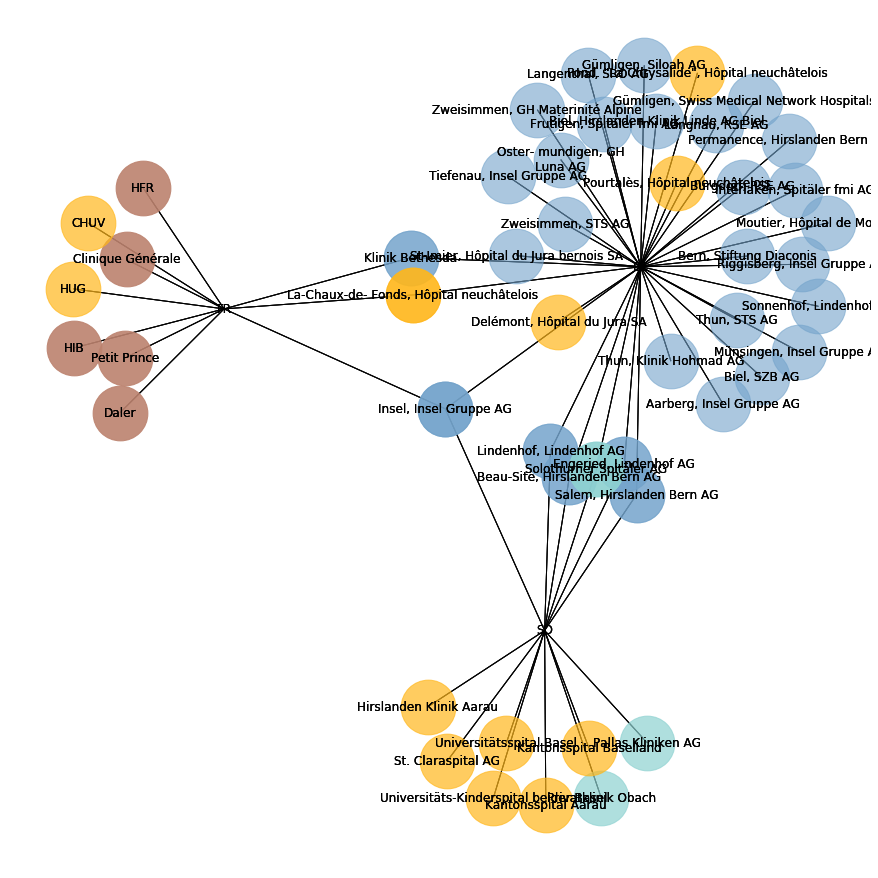

In [19]:

plt.figure(figsize=(12,12))
#freiburg
nx.draw(G, pos, nodelist=fr_list, 
        with_labels=True, node_color='#bc826e', node_size=3000, alpha=0.9)
#bern
nx.draw(G, pos, nodelist=be_list, 
        with_labels=True, node_color='#73a3cb', node_size=3000, alpha=0.6)
#solothurn
nx.draw(G, pos, nodelist=so_list, 
        with_labels=True, node_color='#8ed2d1', node_size=3000, alpha=0.7)
#rest
nx.draw(G, pos, nodelist=rest_list, 
        with_labels=True, node_color='#ffb71c', node_size=3000, alpha=0.7)
